In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import torch
from torch import nn
import torch.nn.functional as f
from torchvision import datasets, transforms

from utils import flat_to_triangular, make_cholesky, plot, clean_curr_axes, onehot

np.random.seed(3)

### $N$-dimensional features, scalar regression target, with covariance

### Problem

We consider a egression problem with N-dimensional features $x$, scalar targets $t$ and known variance $\sigma^2$ We wish to learn a bayesian linear model with learnt basis functions. 

### Case of the known basis function

In the case of a known deterministic N-dimensional basis function $\phi$, le likelihood is expressed as:

\begin{align}
p(t | a, b, x, \sigma) & = \mathcal{N}(a \phi(x) + b, \sigma^2) 
\end{align}

We define the prior over the parameters as an isotropic Gaussian, which gives:

\begin{align}
 p(a) = \mathcal{N}(0,1) \qquad  p(b) = \mathcal{N}(0,1)
\end{align}

It is then possible to compute the posterior of parameters analytically, given $(\mathbf{x}, \mathbf{t})$ the entire dataset:

\begin{align}
p(a,b |\mathbf{t} , \mathbf{x}, \sigma^2) = \frac{p(\mathbf{t} | a, b, \mathbf{x}, \sigma^2) p(a,b)}{p(\mathbf{t}, \mathbf{x})}
\end{align}

$p(\mathbf{t})$ is tractable and constant, hence we can also approximate the posterior using our favorite MCMC methods.


### Learnt basis function

#### Bayes by Backprop

We propose to optimize $\theta$ using maximum likelihood and $a, b$ using Variational Inference, which allows us deriving a lower bound of the marginal log likelihood (with regards to $a,b$) that we can optimize end-to-end. We have:

\begin{align}
\log p(\mathbf{t} | \mathbf{x}, \sigma^2, \theta) & = \log \int_{a,b} \log p(\mathbf{t}, a, b, | \mathbf{x}, \sigma^2, \theta) dadb \\
& = \log \int_{a,b} \log p(\mathbf{t} | a, b, \mathbf{x}, \sigma^2, \theta)p(a,b) dadb \\
& = \log \int_{a,b} q(a,b) p(\mathbf{t} | a, b, \mathbf{x}, \sigma^2, \theta) \frac{p(a,b)}{q(a,b)} dadb \\
& \geq \mathbb{E}_{q(a,b)} \left[ \log  p(\mathbf{t} | a, b, \mathbf{t}, \sigma^2, \theta) \frac{p(a,b)}{q(a,b)} \right] \\
& = \mathbb{E}_q[\log p_{\theta}(\mathbf{t}\ |\ a, b, \mathbf{x})] - \mathrm{KL}(q(a,b) \ ||\ p(a,b)) \\
= \mathcal{L_(t, x)}
\end{align}

#### Modelling the posterior of vector quantities with covariance

In this context, $a$ is a vector of size $N$ and $b$ a scalar. We write $v$ the vector representing all the parameters ${a_i}_a + b$. In this context, we choose to model the approximate posterior of $v$ using a **Multivariate Gaussian** parametrized by a Cholesky factor $L$, which allows us to apply the reparametrization trick [[Pathwise Derivatives Beyond the Reparameterization Trick]](https://arxiv.org/pdf/1806.01851.pdf):

\begin{align}
y \sim \mathcal{N}(\mu, L) \\
y = \mu + L \epsilon \\
\epsilon \sim \mathcal{N}(\mu, I)
\end{align}

The covariance matrix is then defined as:

\begin{aligned} \boldsymbol{\Sigma} &=\mathbb{E}\left[(\mathbf{z}-\mathbb{E}[\mathbf{z} |])(\mathbf{z}-\mathbb{E}[\mathbf{z} |])^{T}\right] \\ &=\mathbb{E}\left[\mathbf{L} \boldsymbol{\epsilon}(\mathbf{L} \boldsymbol{\epsilon})^{T}\right] \\ &=\mathbb{E}\left[\mathbf{L} \boldsymbol{\epsilon} \boldsymbol{\epsilon}^{T} \mathbf{L}^{T}\right] \\ &=\mathbf{L} \mathbb{E}\left[\boldsymbol{\epsilon} \boldsymbol{\epsilon}^{T}\right] \mathbf{L}^{T} \\ &=\mathbf{L} \mathbf{L}^{T} \end{aligned}


We can then write our ELBO as:

\begin{split}
\mathbb{E}_q[\log p_{\theta}(\mathbf{t}\ |\ a, b, \mathbf{x})] =  \mathbb{E}_q \left[ \sum_{x \in \mathbf{x}} \left[ -\frac{1}{2} \log \sigma^2 - \frac{1}{2\sigma^2} [(t - a f_{\theta}(x) - b)^2] + \mathrm{const.} \right] \right] \\
\mathrm{KL}(q(v) \ ||\ p(v)) = -\frac{1}{2} \sum_{i\in v} \left(1 + \log L_{i,i}^2 - \mu_i^2 - L_{i,i}^2\right)
\end{split}

**TODO: check if KL correct**


### Papers

[Gaussian variational approximation with a factor covariance structure](https://arxiv.org/pdf/1701.03208.pdf)

[Pathwise Derivatives Beyond the Reparameterization Trick](https://arxiv.org/pdf/1806.01851.pdf)

[Berkley Kingma ppt](https://berkeley-deep-learning.github.io/cs294-131-s17/slides/VAE%20talk.compressed.pdf)

#### Toy Dataset 1

In [2]:
# N = 150
# sigma = 0.2
# n_classes = 3
# true_a = np.array([0.6, 1, .3]).reshape(-1, 1)
# true_b = 0.2
# # x = np.linspace(-1, 1, N).reshape(-1, 1)
# x = np.random.rand(N, 1) * 2 - 1
# x = np.sort(x, axis=0)
# fx1 = x - 1
# fx2 = x**2
# fx3 = np.sin(12 * x)
# fx = np.concatenate((fx1, fx2, fx3), axis=-1)
# tmp = fx @ true_a + true_b + sigma*np.random.randn(*x.shape)  # function to compute labels

# # Divide data interval in n_classes regions
# # thresholds = np.linspace(tmp.min() - 1e-3, tmp.max() + 1e-3, n_classes+1)  # equal size
# thresholds = np.percentile(tmp, np.linspace(0, 100, n_classes+1))  # balanced classes

# # targets
# t = np.zeros((tmp.shape[0], n_classes), dtype=int)  # one-hot, shape (N, C)
# for i in range(n_classes):
#     t[:, i] = ((thresholds[i] < tmp) * (thresholds[i+1] >= tmp))[:, 0]
# t_values = t * np.arange(n_classes).reshape((1, -1))
# t_values = np.sum(t_values, 1)

# plt.figure(figsize=(10, 7))
# plt.plot(x, fx @ true_a + true_b)
# plt.plot(x, fx, alpha=0.5)
# sns.scatterplot(x[:, 0], tmp[:, 0])
# for i in range(1, n_classes):
#     plt.plot([x[0], x[-1]], np.array([1., 1.]) * thresholds[i], color='k', alpha=0.5)
# plt.show()

# sns.scatterplot(x[:, 0], t_values)
# plt.ylabel('class')
# plt.show()

# print('x shape:', x.shape)
# print('f shape:', fx.shape)
# print('true_a shape:', true_a.shape)
# print('t shape:', t.shape)
# print('t_values shape:', t_values.shape)

# x = torch.tensor(x, dtype=torch.float)
# t_values = torch.tensor(t_values, dtype=torch.long)

In [3]:
batch_size = 128
test_batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

n_classes = 10
print(len(train_loader.dataset))

60000


#### Features extractor and stochastic layer

Define function $f_{\theta}$ to extract features $\mathbf{h} = f_{\theta}(x)$, with parameters $\theta$ to be optimized. The features $\mathbf{h}$ have size $m$, the weight matrix $\mathbf{a}$ has shape $m \times k$, the bias $\mathbf{b}$ has size $k$, and $k$ is the number of classes. Logits are $\mathbf{h \cdot a} + \mathbf{b}$, with $\mathbf{a}$ and $\mathbf{b}$ multivariate Normal rvs with full covariance (including correlation between $\mathbf{a}$ and $\mathbf{b}$).

The stochastic layer has no state, it's only used to get samples from $\mathcal{N}(\mu, \Sigma)$, and to compute the KL divergence from a prior $\mathcal{N}(0, I)$ to a variational distribution $q = \mathcal{N}(\mu, \Sigma)$.

In [4]:
class FeaturesExtractor(nn.Module):
    def __init__(self, n_out):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(1, 32, 5, stride=2), nn.LeakyReLU(),
            nn.Conv2d(32, 64, 5, stride=2), nn.LeakyReLU(),
        )
        self.fcs = nn.Sequential(
            nn.Linear(4*4*64, 256), nn.LeakyReLU(),
            nn.Linear(256, n_out), nn.LeakyReLU(),
        )
        
    def forward(self, x):
        x = self.convs(x)
        x = x.view(x.size(0), -1)
        return self.fcs(x)
    
    
class CovarianceStochasticLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, mu_q, cholesky):
        eps = torch.randn_like(mu_q)
        return mu_q + cholesky @ eps
    
    def forward_diagonal(self, mu_q, logvar_q):
        eps = torch.randn_like(mu_q)
        std = (logvar_q/2).exp()
        return mu_q + std * eps

    def get_kl(self, mu_q, logvar_q):
        """KL from standard normal. Shape is irrelevant, KL is summed over all dimensions."""
        kl = -0.5 * (1 + logvar_q - mu_q.pow(2) - logvar_q.exp())
        return kl.sum()


### Optimize

Here we maximize the ELBO $\mathcal{L}$ with respect to variational parameters $\mu_a, \sigma_a, \mu_b, \sigma_b$, the NN parameters $\theta$, and the noise std $\sigma$.

In [5]:
last_layer_size = 32
a_shape = (last_layer_size, n_classes)  # shape of stochastic weight matrix
a_size = np.prod(a_shape)
b_size = n_classes

features = FeaturesExtractor(n_out=last_layer_size)
stochastic = CovarianceStochasticLayer()
l_rate = 1e-4
epochs = 1000
n_samples = 10  # MC samples per example
n_parameters = a_size + b_size
mu_ab = nn.Parameter(torch.zeros((n_parameters)))  # for a and b

# diagonal covariance
logvar_ab = nn.Parameter(-3 * torch.ones((n_parameters)))

# off-diagonal covariance
cov_ab_params = nn.Parameter(torch.zeros((n_parameters*(n_parameters-1)//2)).normal_() * 0.01)

# print("Cholesky:\n", make_cholesky(logvar_ab, cov_ab))

optimiser = torch.optim.Adam(list(features.parameters()) + [mu_ab, logvar_ab, cov_ab_params], lr = l_rate)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
step = 0
for epoch in range(1, epochs + 1):
    features.train()
    for batch_idx, (x, t) in enumerate(train_loader):
        x, t = x.to(device), t.to(device)
        optimiser.zero_grad()
        h = features(x)
        cov_ab = flat_to_triangular(cov_ab_params)
        elbo = torch.zeros((n_samples), device=x.device)
        acc = 0.0
        for i in range(n_samples):
            # Sample once from q(a) q(b)
            ab_sample = stochastic(mu_ab, make_cholesky(logvar_ab, cov_ab))
#             ab_sample = mu_ab
            a, b = ab_sample[:-b_size], ab_sample[-b_size:]
            a = a.view(a_shape)
            b = b.unsqueeze(0)

            y = h @ a + b   # stochasticity here only comes from a and b

            # Reconstruction loss, estimated by MC
            recons_i = f.cross_entropy(y, t)

            # Accuracy
            pred_class = torch.max(y.detach(), dim=1)[1]   # tensor of indices
            acc += torch.mean((t==pred_class).float()).item()

            # KL loss, both analytic and by MC
            #kl_estimate = 0.5*expected_kl_term - 0.5*logvar_ab.sum()
            kl_i = stochastic.get_kl(mu_ab, logvar_ab) / len(train_loader.dataset)
            #kl = (a**2).sum() + b**2 - ((a - mu_a)**2/logvar_a.exp()).sum() - (b - mu_b)**2/logvar_b.exp()

            elbo[i] = - recons_i - kl_i

        acc = acc/n_samples

        # IW averaging
        elbo = elbo.mean() # log_sum_exp(elbo, dim=0, sum_op=torch.mean)

        loss = - elbo
        loss.backward()
        optimiser.step()
        step += 1
        if step % 50 == 0:
            print(f'step {step} : loss {loss.item():.3f} ELBO {elbo.item():.3f}  Reconstruction '
                  f'{recons_i.sum().item()}  KL {kl_i.sum().item()}   acc {acc:.3f}')


step 50 : loss 2.339 ELBO -2.339  Reconstruction 2.3466811180114746  KL 0.00563208619132638   acc 0.112
step 100 : loss 2.352 ELBO -2.352  Reconstruction 2.401611804962158  KL 0.0056265974417328835   acc 0.099
step 150 : loss 2.333 ELBO -2.333  Reconstruction 2.281141757965088  KL 0.005621090065687895   acc 0.109
step 200 : loss 2.324 ELBO -2.324  Reconstruction 2.3426904678344727  KL 0.005616265814751387   acc 0.116
step 250 : loss 2.314 ELBO -2.314  Reconstruction 2.250870943069458  KL 0.005612965207546949   acc 0.119
step 300 : loss 2.274 ELBO -2.274  Reconstruction 2.343751907348633  KL 0.005611761007457972   acc 0.121
step 350 : loss 2.269 ELBO -2.269  Reconstruction 2.241140365600586  KL 0.005613010376691818   acc 0.109
step 400 : loss 2.196 ELBO -2.196  Reconstruction 2.156245231628418  KL 0.005615697707980871   acc 0.158
step 450 : loss 2.043 ELBO -2.043  Reconstruction 1.9087858200073242  KL 0.0056208660826087   acc 0.247
step 500 : loss 2.216 ELBO -2.216  Reconstruction 1.963

KeyboardInterrupt: 

### Visualization

First we sample $a,b \sim q(a,b)$ according to the learned variational parameters. Get $N$ samples $a_i$ and $b_i$. Then sample from predictive distribution
$$t_i = a_i f_{\theta}(x_i) + b_i + \sigma \epsilon_i$$
with $\epsilon_i$ iid samples from $\mathcal{N}(0,1)$.

In [ ]:
# ### Get classifier output for the whole dataset and for many samples of the last layer's weights
# n_samples = 50       
# with torch.no_grad():
#     # Compute deterministic NN output
#     h = features(x)
#     cov_ab = flat_to_triangular(cov_ab_params)
#     y_all = []
#     for i in range(n_samples):
#         # Sample last layer's weights from posterior q(a, b)
#         ab_sample = stochastic(mu_ab, make_cholesky(logvar_ab, cov_ab))
#         a, b = ab_sample[:-b_size], ab_sample[-b_size:]
#         a = a.view(a_shape)
#         b = b.unsqueeze(0)
        
#         # Compute last layer output (the logits) with the weights just sampled
#         y = h @ a + b    # shape: (N, n_classes)
        
#         y_all.append(y.softmax(1).unsqueeze(0).cpu().numpy())

# y_all = np.concatenate(y_all, axis=0)  # shape: (n_samples, N, n_classes)


# ### Get predictions (argmax) for all samples of weights (a,b)
# pred_class = np.argmax(y_all, axis=-1)   # tensor of indices, shape (n_samples, N)
# pred_class_onehot = onehot(pred_class)
# pred_class_mean = pred_class_onehot.mean(0)   # shape (N, n_classes)
# # pred_class_mean: for each input point a vector of size n_classes that sums to 1


# ### Get confusion matrix based on those samples
# conf_matrix = np.zeros((n_classes, n_classes))
# for i in range(N):
#     conf_matrix[t_values[i]] += pred_class_mean[i]
# conf_matrix /= conf_matrix.sum(1, keepdims=True)



# ### Show confusion matrix
# plt.imshow(conf_matrix)
# plt.colorbar()
# plt.grid(False)
# clean_curr_axes()
# plt.title('Confusion matrix (rows sum to 1)')
# plt.xlabel('Predicted top class')
# plt.ylabel('True class')
# plt.show()


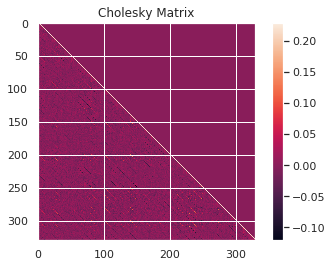

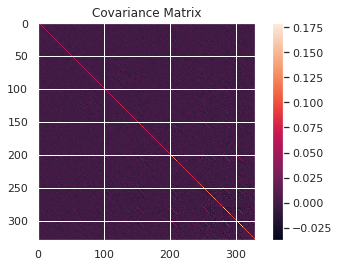

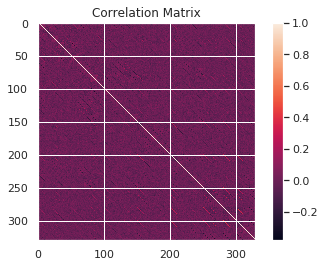

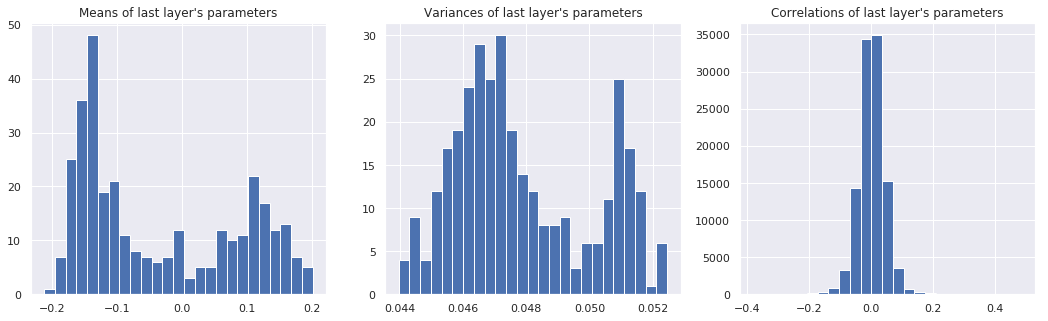

In [17]:
L = make_cholesky(logvar_ab, cov_ab).detach().cpu().numpy()
Cov = L @ L.T
inv_stds = np.diag(np.diag(Cov)**(-0.5))
Corr = inv_stds @ Cov @ inv_stds

plt.title("Cholesky Matrix")
plt.imshow(L)
plt.colorbar()
plt.show()

plt.title("Covariance Matrix")
plt.imshow(Cov)
plt.colorbar()
plt.show()

plt.title("Correlation Matrix")
plt.imshow(Corr)
plt.colorbar()
plt.show()

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.title("Means of last layer's parameters")
plt.hist(mu_ab.detach(), bins=25)
plt.subplot(1, 3, 2)
plt.title("Variances of last layer's parameters")
plt.hist(logvar_ab.exp().detach(), bins=25)
plt.subplot(1, 3, 3)
plt.title("Correlations of last layer's parameters")  # corr coefficients between pairs of DIFFERENT variables
correlations = Corr[~np.eye(Corr.shape[0], dtype=bool)]
plt.hist(correlations, bins=25)
plt.show()